# CS 536 : Pruning Decision Trees

#### Submitted by Nitin Reddy Karolla (nrk60)

In [45]:
# Importing the required packages for the assignment

import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from statistics import mode
from multiprocessing import Pool

%matplotlib inline

### 1) Write a function to generate m samples of (X, Y), and another to fit a tree to that data using ID3. Write a third function to, given a decision tree f, estimate the error rate of that decision tree on the underlying data, err(f). Do this repeatedly for a range of m values, and plot the ‘typical’ error of a tree trained on m data points as a function of m. Does this agree with your intuition?


In [46]:
def data_generator(m):
    """
    Input : 
        m - Number of samples
    
    Output : 
        Dataframe with k+1 columns i.e. k features that represent X 
        and 1 the represents Y
    """
    colnames = [ 'X'+ str(i)  for i in range(21)]
    
    X = [] 
    for j in range(m):
        y = []
        a = np.random.binomial(1, p=0.5, size= 1)[0]
        y.append(a)
        for i in range(14):
            x = np.random.binomial(1, p=0.75, size= 1)[0]
            if x == 1:
                y.append(y[i])
            else:
                y.append(1-y[i])
        for i in range(6):
            x = np.random.binomial(1, p = 0.5, size = 1)[0]
            y.append(x)
        X.append(y)
     
    df = pd.DataFrame(data= X, columns= colnames)
    
    #Generating the Y
    Y = []
    for i in X:
        if i[0] == 0:
            y = mode(i[1:8])
        else :
            y = mode(i[8:15])
        Y.append(y)
    
    #Generate column names
    df['Y'] = pd.Series(data = Y)
    return(df)

In [47]:
class Node():
    """
    Node is a data structure which will be used for decision trees.
    
    Input :
        data = training data post split is stored
        rule = feature on which the split led to this node and the 
        value of the feature
        child = nodes of children of all this node are present 
        after the split
    """
    def __init__(self,
                 data = None,
                 rule = None,
                 child = None,
                 depth = None
                ):
        self.data = data
        self.rule = rule
        self.child = child
        self.depth = depth

In [48]:
class Decision_Tree_ID3():
    """
    Decision Tree ID3 is trained on data with a target variable. It 
    is built on split variable which is indentified using the logic 
    of information gain 
    """
    def __init__(self, root = None, termination_depth = None, 
                 min_leaf_size = None, sig_threshold = None, var = None):
        self.root = root
        self.termination_depth = termination_depth
        self.min_leaf_size = min_leaf_size
        self.sig_threshold = sig_threshold
        if var == None:
            self.var = []
        
    def _entropy(self, data, variable):
        """
        Calcuates the entropy for the given data and target variable
        """
        entropy_value = sum([(-data[variable].value_counts()[i]/ 
                              data[variable].count()) * np.log2((
            data[variable].value_counts()[i]/ 
            data[variable].count()) + 0.00000001) 
                             for i in data[variable].unique()])
        return entropy_value
    
    
    def _information_gain(self, data, variable, target):
        """
        Calculates the information gain for the given variable and data
        """
        infomation_content = sum([data[variable].value_counts()[i]/
                                  data[variable].count()
                                  * self._entropy(data[data[variable]== i], 
                                                 target) 
                                  for i in data[variable].unique()])
        info_gain = self._entropy(data, target) - infomation_content
        return(info_gain)
    
    
    def _split_variable_identification(self, data, target):
        """
        Identifies the split variable based on data and target
        """
        #loop through all features and calculate information gain for each feature
        variable_ig_required = list(data.columns)
        variable_ig_required.remove('Y')
        ig_values = [(i, self._information_gain(data,i,'Y')) 
                     for i in variable_ig_required]
        if len(ig_values) != 0:
            split_variable = max(ig_values, key = lambda item : item[1])
        else:
            split_variable = (0,0)
        return(split_variable)
    
    def _chi_square(self,data,var,target):
        chi_square = []
        for i in data[var].unique():
            for j in data[target].unique():
                expected_x = (data[var].value_counts()[i]/len(data[var]))
                expected_y = (data[target].value_counts()[j]/len(data[target]))
                expected = expected_x * expected_y * len(data[var])
                #print(expected)

                observed = data[(data[var] == i) & (data[target] == j )].shape[0]
                #print(observed)

                out = (expected - observed)**2 / expected
                chi_square.append(out)
        return (sum(chi_square))
    

    def _split_data(self, data, split_variable): 
        """
        Splits the data after identifying the split variable, assigns 
        data and rule to the node.
        """
        splitted_data = [Node(data = (data[data[split_variable] == i].
                                      drop(split_variable,1)),
                              rule = (split_variable,i)) 
                         for i in data[split_variable].unique()]
        return(splitted_data)
    
    
    def fit(self, data, target):
        """
        Fit is used to fit decision trees on the data for a given target variable
        """
        if type(data) != Node:
            data = Node(data = data, depth = 0)
            self.root = data
        
        #Terminating Conditions
        if self._split_variable_identification(data.data, target)[1] == 0 :
            return
        if self.termination_depth != None:
            if data.depth == self.termination_depth:
                return
        if self.min_leaf_size != None:
            if data.data.shape[0] <= self.min_leaf_size:
                return
        
        split_variable = self._split_variable_identification(data.data, target)[0]
        
        #Terminating Conditions
        if self.sig_threshold != None:
            if self._chi_square(data.data,split_variable,target) < self.sig_threshold:
                return
        
        #Adding depth to the node
        data.child = self._split_data(data.data, split_variable)
        for i in data.child:
            i.depth = data.depth + 1
               
        for i in data.child:
            if i.data['Y'].nunique() != 1:
                self.fit(i, target)
            
    
    def get_rules(self, model = None ,ruleList = None):
        """
        Returns the rules for each leaf and the major class in the leaf
        """
        if ruleList == None:
            ruleList = []
        if model == None:
            model = self.root
        ruleList.append(model.rule)
        if model.child == None:
            ruleList.append(model.data['Y'].mode()[0])
            return print(ruleList[1:])
        for i in model.child:
            self.get_rules(i,ruleList.copy())
            
    def get_irrelevant_variable(self, irrelevant_variables, model = None ):
        """
        Returns the count of irrelevant variables present in the decision tree
        """ 
        if model == None:
            model = self.root
        if model.child == None:
            return
        for i in model.child:
            if i.rule[0] in irrelevant_variables:
                self.var.append(i.rule[0])
            self.get_irrelevant_variable(irrelevant_variables,i)
        return list(set(self.var))
    

    def _predict_row(self, model, row):
        """
        This function returns the prediction for the a single sample of 
        data using the fitted data
        """
        if model.child == None:
            return(model.data['Y'].mode()[0])

        variable = model.child[0].rule[0]
        row_value = row[variable]
        for i in model.child:
            if i.rule[1] == row_value:
                return self._predict_row(i, row)
            
    def predict(self, test):
        """
        Predict funtion will take an input data and return the prediction
        based on the fitted decision tree
        """
        predicted_y = []
        for i in test.iterrows():
            x = i[1]
            y = self._predict_row(self.root, x)
            predicted_y.append(y)
        return pd.Series(predicted_y)
    
    def training_error(self):
        """
        Returns the training error of the  fitted decision tree
        """
        predict_train = self.predict(self.root.data)
        return (1 -sum(self.root.data['Y'] == predict_train)/ len(self.root.data))
    
    def error(self, test, target):
        """
        Returns the training error of the  fitted decision tree
        """
        predict_test = self.predict(test.drop(target, axis = 1))
        return (1 -sum(test[target] == predict_test)/ len(test))

In [49]:
def typical_error(model, test_data_size, simulations = 50):
    """
    Generate error for similations for a generated test data and 
    given decision tree.
    """
    error = []
    for i in range(simulations):
        test_data = data_generator(test_data_size)
        predicted_y = model.predict(test_data)
        error_current = 1 -(sum(test_data['Y'] == predicted_y)/ len(test_data))
        error.append(error_current)
    return error

In [50]:
#Defining the repetitions values for generating m samples of training data
start = 400
end = 4000
step = 100

In [51]:
err_abs = []
m = []
for i in tqdm(range(start,end,step)):
    data = data_generator(i)
    dt = Decision_Tree_ID3()
    dt.fit(data, 'Y')
    err_f = typical_error(dt, 10)
    err_final = sum(err_f)/len(err_f)
    err_train = dt.training_error()
    m.append(i)
    #print( err_final, err_train)
    err_abs.append(abs(err_final-err_train))




  0%|                                                                                           | 0/36 [00:00<?, ?it/s]


  3%|██▎                                                                                | 1/36 [00:12<07:08, 12.23s/it]


  6%|████▌                                                                              | 2/36 [00:27<07:24, 13.09s/it]


  8%|██████▉                                                                            | 3/36 [00:44<07:57, 14.46s/it]


 11%|█████████▏                                                                         | 4/36 [00:58<07:38, 14.32s/it]


 14%|███████████▌                                                                       | 5/36 [01:16<07:52, 15.24s/it]


 17%|█████████████▊                                                                     | 6/36 [01:37<08:28, 16.95s/it]


 19%|████████████████▏                                                                  | 7/36 [01:59<08:53, 18.41s/it]


 22%|████████████████

Text(0.5,1,'Marginal error vs the training size (m)')

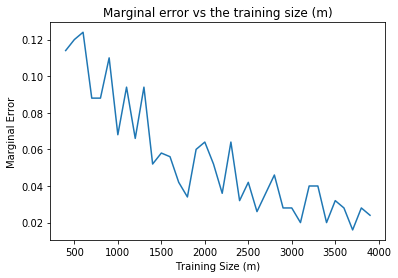

In [52]:
sns.lineplot(m,err_abs)
plt.xlabel("Training Size (m)")
plt.ylabel("Marginal Error")
plt.title("Marginal error vs the training size (m)")

We expect that the Margincal error to decrease as the m increase, as the decision tree get to see more data and learn more. This can also be seen in plot above.

### 2) Note that X15 through X20 are completely irrelevant to predicting the value of Y . For a range of m values, repeatedly generate data sets of that size and fit trees to that data, and estimate the average number of irrelevant variables that are included in the fit tree. How much data would you need, typically, to avoid fitting on this noise?

In [37]:
irrelevant_variables = ['X15','X16','X17','X18','X19','X20']

In [40]:
def avg_irr_var(size, irrelevant_variables = irrelevant_variables, model_simulations = 5):
    out = []
    for i in range(model_simulations):
        tree = Decision_Tree_ID3()
        data = data_generator(m = size)
        tree.fit(data, 'Y')
        out.append(len(tree.get_irrelevant_variable(irrelevant_variables= irrelevant_variables)))
    return(sum(out)/len(out))

In [41]:
irv_m = [100,500,1000,2500,5000,10000,50000,100000,250000]
irv_var_average = []
for i in tqdm(irv_m):
    irv_var_average.append(avg_irr_var(size = i))




  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


 11%|█████████▎                                                                          | 1/9 [00:23<03:11, 23.92s/it]


 22%|██████████████████▋                                                                 | 2/9 [01:33<04:22, 37.56s/it]


 33%|████████████████████████████                                                        | 3/9 [03:18<05:47, 57.98s/it]


 44%|█████████████████████████████████████▎                                              | 4/9 [06:00<07:25, 89.11s/it]


 56%|██████████████████████████████████████████████                                     | 5/9 [09:53<08:48, 132.11s/it]


 67%|███████████████████████████████████████████████████████▎                           | 6/9 [14:51<09:05, 181.93s/it]


 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [21:54<08:28, 254.17s/it]


 89%|████████████████

Text(0.5,1,'Training size vs Avg Irrevelant Variables')

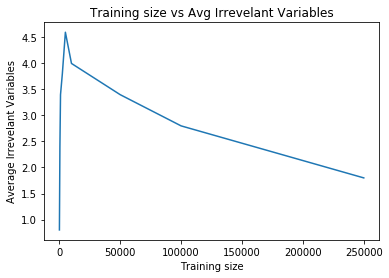

In [43]:
sns.lineplot(irv_m,irv_var_average)
plt.xlabel("Training size")
plt.ylabel("Average Irrevelant Variables")
plt.title("Training size vs Avg Irrevelant Variables")

As we can see the average number of irrelevant variables decrease with increase in training data for the decision trees. Once the training data reaches 250000, the number of irrelevant variables reduces to 1.9, once the decision tree sees the complete data i.e. $ 2^{15} $ unique data points, the tree would likely understand that X15 to X20 are noise varaibles, and would avoid adding them as split variable

### 3) Generate a data set of size m = 10000, and set aside 8000 points for training, and 2000 points for testing. The remaining questions should all be applied to this data set.

In [19]:
master_data = data_generator(10000)

In [20]:
train = master_data.sample(frac=0.8,random_state=200)
test = master_data.drop(train.index)

train.reset_index(inplace= True, drop = True)
test.reset_index(inplace= True, drop = True)

### a) Pruning by Depth: 
#### Consider growing a tree as a process - running ID3 for instance until all splits up to depth d have been performed. Depth d = 0 should correspond to no decisions - a prediction for Y is made just on the raw frequencies of Y in the data. Plot, as a function of d, the error on the training set and the error on the test set for a tree grown to depth d. What does your data suggest as a good threshold depth?


In [10]:
depth = list(range(1,22))
training_error = []
test_error = []
for i in range(1,22):
    tree = Decision_Tree_ID3(termination_depth= i)
    tree.fit(train, 'Y')
    training_error.append(tree.training_error())
    test_error.append(tree.error(test, 'Y'))

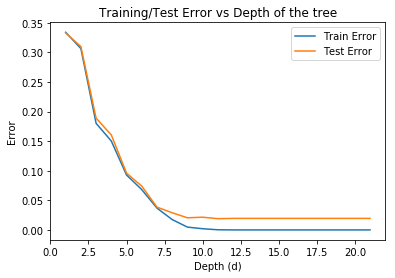

In [28]:
sns.lineplot(list(range(1,22)),training_error)
plt.xlabel("Depth (d)")
plt.ylabel("Error")
plt.title("Training/Test Error vs Depth of the tree")
sns.lineplot(list(range(1,22)), test_error)
plt.legend(["Train Error", "Test Error"])

As expected the training decreases, as the model complexity i.e. depth in this case increases. After the depth reached 9, there is not really any improvement in error of Test data. So we can consider, depth = 9 as good threshold depth for this data.

### b) Pruning by Sample Size:

#### The less data a split is performed on, the less ‘accurate’ we expect the result of that split to be. Let s be a threshold such that if the data available at a node in your decision tree is less than or equal to s, you do not split and instead decide Y by simple majority vote (ties broken by coin flip). Plot, as a function of s, the error on the training set and the error on the testing set for a tree split down to sample size s. What does your data suggest as a good sample size threshold?

In [71]:
leaf_size = []
training_error = []
test_error = []
for i in range(0,750, 25):
    tree = Decision_Tree_ID3(min_leaf_size= i)
    tree.fit(train, 'Y')
    training_error.append(tree.training_error())
    test_error.append(tree.error(test, 'Y'))
    leaf_size.append(i)

    
leaf_size.reverse()
training_error.reverse()
test_error.reverse()

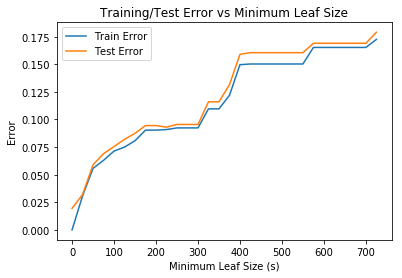

In [88]:
sns.lineplot(leaf_size,training_error)
plt.xlabel("Minimum Leaf Size (s)")
plt.ylabel("Error")
plt.title("Training/Test Error vs Minimum Leaf Size")
sns.lineplot(leaf_size, test_error)
plt.legend(["Train Error", "Test Error"])

As expected the training error decreases, as the leaf size in this case increases. Model complexity is expected to decrease with increase in leaf size. After the leaf size reached 25, there is not really any improvement in error of Test data. So we can consider, minimun leaf size = 25 as good threshold for this data. However, the test error is really low i.e. less than 2% on fully grown tree, so we cannot really conclude on any minimum leaf size threshold.

### c) Pruning by Significance: 

#### If a variable X is independent of Y , then X has no value as a splitting variable. We can use something like the χ2 -test to estimate how likely a potential splitting variable is to be independent, based on the test statistic T compared to some threshold T0 (in the usual 2-outcome case, T0 = 3.841 is used to test at a significance level of p = 5% - see notes for more explanation). Given T0, if given the data for X the value of T is less than T0, it is deemed not significant and is not used for splitting. If given the data for X the value of T is greater than T0, it is deemed significant, and used for splitting. Plot, as a function of T0, the error on the training set and the error on the testing set for a tree split at significance threshold T0. What does your data suggest as a good threshold for significance?

In [22]:
threshold2 = []
training_error2 = []
test_error2 = []
for i in np.arange(0, 10, 0.5):
    tree = Decision_Tree_ID3(sig_threshold = i)
    tree.fit(train, 'Y')
    training_error2.append(tree.training_error())
    test_error2.append(tree.error(test, 'Y'))
    threshold2.append(i)

In [23]:
threshold = []
training_error = []
test_error = []
for i in np.arange(10, 25, 2):
    tree = Decision_Tree_ID3(sig_threshold = i)
    tree.fit(train, 'Y')
    training_error.append(tree.training_error())
    test_error.append(tree.error(test, 'Y'))
    threshold.append(i)

In [24]:
thres_final = list(threshold2) + list(threshold)
training_error_final = training_error2 + training_error
test_error_final = test_error2 + test_error

In [25]:
thres_final.reverse()
training_error_final.reverse()
test_error_final.reverse()

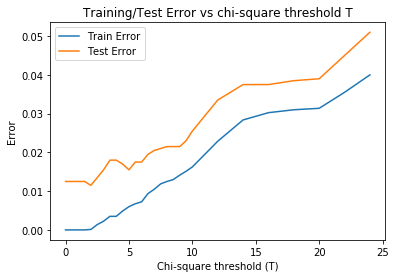

In [26]:
sns.lineplot(thres_final,training_error_final)
plt.xlabel("Chi-square threshold (T)")
plt.ylabel("Error")
plt.title("Training/Test Error vs chi-square threshold T")
sns.lineplot(thres_final, test_error_final)
plt.legend(["Train Error", "Test Error"])

As we keep a higher threshold for chi-sqaure significance test, we see that most of the variable are not considered in the tree which results in increase of the training error and test error. Again since the error on the test error is really low, its difficult to decide on the the threshold. p= 5% (T = 3.841) seems to be a good threshold for now.

### 5) Repeat the computation of Problem 2, growing your trees only to depth d as chosen in 3.a. How does this change the likelihood or frequency of including spurious variables in your trees?


In [33]:
d = 9

In [34]:
def avg_irr_var_new(m, irrelevant_variables = irrelevant_variables, model_simulations = 5):
    out = []
    for i in tqdm(range(model_simulations)):
        data = data_generator(m)
        tree = Decision_Tree_ID3(termination_depth= d)
        tree.fit(data, 'Y')
        out.append(len(tree.get_irrelevant_variable(irrelevant_variables= irrelevant_variables)))
    return(sum(out)/len(out))

In [35]:
depth_irv = [100,500,1000,2500,5000,10000,50000,100000]
irv_var_d = []
for i in tqdm(depth_irv):
    irv_var_d.append(avg_irr_var_new(i))



  0%|                                                                                            | 0/8 [00:00<?, ?it/s]


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


 20%|████████████████▊                                                                   | 1/5 [00:03<00:14,  3.67s/it]


 40%|█████████████████████████████████▌                                                  | 2/5 [00:08<00:12,  4.05s/it]


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:13<00:08,  4.35s/it]


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:18<00:04,  4.48s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.67s/it]




 12%|██████████▌                                                                         | 1/8 [00:23<02:44, 23.57s/it]


  0%|               

Text(0.5,1,'Sample Size vs Average Irrevelant Variables w Depth Pruning')

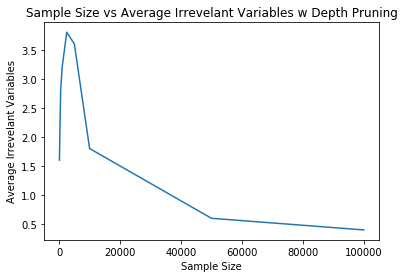

In [44]:
sns.lineplot(depth_irv,irv_var_d)
plt.xlabel("Sample Size")
plt.ylabel("Average Irrevelant Variables")
plt.title("Sample Size vs Average Irrevelant Variables w Depth Pruning")

Post assigning pruning conditions of depth = 9, we see that average of number of spurious variables included in the tree reduces as compared to a fully grown tree.

### 6) Repeat the computation of Problem 2, splitting your trees only to sample size s as chosen in 3.b. How does this change the likelihood or frequency of including spurious variables in your trees?

In [12]:
def avg_irr_var_new(m, irrelevant_variables = irrelevant_variables, model_simulations = 5):
    out = []
    for i in tqdm(range(model_simulations)):
        data = data_generator(m)
        tree = Decision_Tree_ID3(min_leaf_size = 50)
        tree.fit(data, 'Y')
        out.append(len(tree.get_irrelevant_variable(irrelevant_variables= irrelevant_variables)))
    return(sum(out)/len(out))

In [13]:
leaf_size_irv = [100,500,1000,2500,5000,10000,50000,100000]
irv_var_ls = []
for i in tqdm(leaf_size_irv):
    irv_var_ls.append(avg_irr_var_new(m = i))

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [22:51<00:00, 277.92s/it]


Text(0.5,1,'Training size vs Avg Irrevelant Variables w/ leaf size pruning')

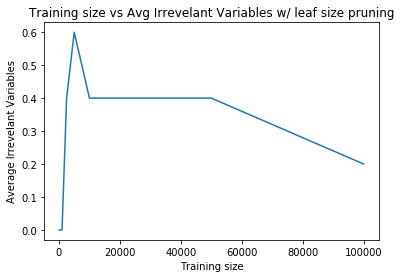

In [15]:
sns.lineplot(leaf_size_irv,irv_var_ls)
plt.xlabel("Training size")
plt.ylabel("Average Irrevelant Variables")
plt.title("Training size vs Avg Irrevelant Variables w/ leaf size pruning")

Post assigning pruning conditions of min leaf size = 50, we see that average of number of spurious variables included in the tree reduces as compared to a fully grown tree. They follow as decreasing trend as m increase which is as expected.

### 7) Repeat the computation of Problem 2, splitting your trees only at or above threshold level T0 as chosen in 3.c.How does this change the likelihood or frequency of including spurious variables in your trees?

In [13]:
def avg_irr_var_new(m, irrelevant_variables = irrelevant_variables, model_simulations = 8):
    out = []
    for i in tqdm(range(model_simulations)):
        data = data_generator(m)
        tree = Decision_Tree_ID3(sig_threshold = 3.841)
        tree.fit(data, 'Y')
        out.append(len(tree.get_irrelevant_variable(irrelevant_variables= irrelevant_variables)))
    return(sum(out)/len(out))

In [14]:
avg_irre_var_t = []
m_t = [100,500,1000,2500,5000,10000,50000,75000,100000]
for i in tqdm(m_t):
    avg_irre_var_t.append(avg_irr_var_new(i))

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [58:50<00:00, 583.16s/it]


Text(0.5,1,'Training data size vs Average Irrevelant Variables w Chi_square T')

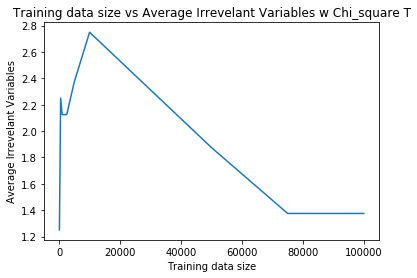

In [16]:
sns.lineplot(m_t,avg_irre_var_t)
plt.xlabel("Training data size")
plt.ylabel("Average Irrevelant Variables")
plt.title("Training data size vs Average Irrevelant Variables w Chi_square T")

Post assigning pruning conditions of significa threshold = 3.841, we see that average of number of spurious variables included in the tree reduces as compared to a fully grown tree. They follow as decreasing trend as m increase which is as expected.